Title
===


Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline

import numpy as np
import pymc3 as pm
import scipy
import seaborn as sns

import matplotlib.pyplot as plt

import thinkbayes2
import thinkplot

/home/downey/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simulating hockey

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, `lambda`, in goals per game.

For the first example, we'll assume that `lambda` is known (somehow) to be 2.7.  Since regulation play (as opposed to overtime) is 60 minutes, we can compute the goal scoring rate per minute.

In [90]:
lam_per_game = 2.7
min_per_game = 60
lam_per_min = lam_per_game / min_per_game
lam_per_min, lam_per_min**2

(0.045000000000000005, 0.0020250000000000003)

If we assume that a goal is equally likely during any minute of the game, and we ignore the possibility of scoring more than one goal in the same minute, we can simulate a game by generating one random value each minute.

In [91]:
np.random.random(min_per_game)

array([0.88708578, 0.66478919, 0.57513002, 0.88568491, 0.30692748,
       0.0118273 , 0.67670424, 0.15370589, 0.07586497, 0.93824382,
       0.90087772, 0.22445015, 0.23880107, 0.31518831, 0.45712327,
       0.09929617, 0.1147031 , 0.60093651, 0.83543978, 0.86059693,
       0.17613479, 0.6010503 , 0.92481195, 0.80854094, 0.69262696,
       0.40509311, 0.90924084, 0.05897305, 0.69938444, 0.98584333,
       0.6455767 , 0.35258225, 0.11147996, 0.61437   , 0.9853087 ,
       0.37380117, 0.45389729, 0.64923269, 0.49222124, 0.29551056,
       0.50144983, 0.48373618, 0.2511476 , 0.43561128, 0.34185198,
       0.72173033, 0.53915549, 0.88339058, 0.36338727, 0.5883524 ,
       0.72186773, 0.67900801, 0.01310658, 0.50385698, 0.05367847,
       0.81696896, 0.87530324, 0.77512518, 0.921932  , 0.5956639 ])

If the random value is less than `lam_per_min`, that means we score a goal during that minute.

In [92]:
np.random.random(min_per_game) < lam_per_min

array([ True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

So we can get the number of goals scored by one team like this:

In [93]:
np.sum(np.random.random(min_per_game) < lam_per_min)

2

I'll wrap that in a function.

In [94]:
def half_game(lam_per_min, min_per_game=60):
    return np.sum(np.random.random(min_per_game) < lam_per_min)

And simulate 10 games.

In [95]:
size = 10
sample = [half_game(lam_per_min) for i in range(size)]
sample

[6, 6, 3, 1, 4, 3, 1, 1, 2, 3]

If we simulate 1000 games, we can see what the distribution looks like.  The average of this sample should be close to `lam_per_game`.

In [96]:
size = 1000
sample_sim = [half_game(lam_per_min) for i in range(size)]
np.mean(sample_sim), lam_per_game

(2.725, 2.7)

## PMFs

To visualize distributions, I'll start with a probability mass function (PMF), which I'll implement using a `Counter`.



In [97]:
from collections import Counter

class Pmf(Counter):
    
    def normalize(self):
        """Normalizes the PMF so the probabilities add to 1."""
        total = sum(self.values())
        for key in self:
            self[key] /= total
            
    def sorted_items(self):
        """Returns the outcomes and their probabilities."""
        return zip(*sorted(self.items()))

Here are some functions for plotting PMFs.

In [98]:
plot_options = dict(linewidth=3, alpha=0.6)

def plot_pmf(sample):
    """Compute and plot a PMF."""
    pmf = Pmf(sample)
    pmf.normalize()
    xs, ps = pmf.sorted_items()
    plt.bar(xs, ps, **plot_options)
    
def pmf_goals():
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel('PMF')
    plt.title('Distribution of goals scored')

Here's what the results from the simulation look like.

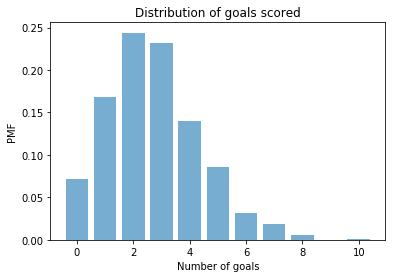

In [99]:
plot_pmf(sample_sim)
pmf_goals()

## Analytic distributions

For the simulation we just did, we can figure out the distribution analytically: it's a binomial distribution with parameters `n` and `p`, where `n` is the number of minutes and `p` is the probability of scoring a goal during any minute.

We can use NumPy to generate a sample from a binomial distribution.

In [100]:
n = min_per_game
p = lam_per_min
sample_bin = np.random.binomial(n, p, size)
np.mean(sample_bin)

2.663

And confirm that the results are similar to what we got from the model.

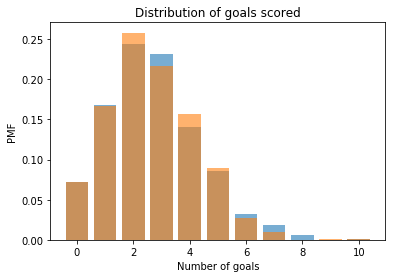

In [101]:
plot_pmf(sample_sim)
plot_pmf(sample_bin)
pmf_goals()

But plotting PMFs is a bad way to compare distributions.  It's better to use the cumulative distribution function (CDF).

In [102]:
def plot_cdf(sample):
    """Compute and plot the CDF of a sample."""
    pmf = Pmf(sample)
    xs, freqs = pmf.sorted_items()
    ps = np.cumsum(freqs, dtype=np.float)
    ps /= ps[-1]
    plt.plot(xs, ps, **plot_options)
    
def cdf_rates():
    """Decorate the axes."""
    plt.xlabel('Goal scoring rate (mu)')
    plt.ylabel('CDF')
    plt.title('Distribution of goal scoring rate')

def cdf_goals():
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel('CDF')
    plt.title('Distribution of goals scored')

def plot_cdfs(*sample_seq):
    """Plot multiple CDFs."""
    for sample in sample_seq:
        plot_cdf(sample)
    cdf_goals()

Now we can compare the results from the simulation and the sample from the biomial distribution.

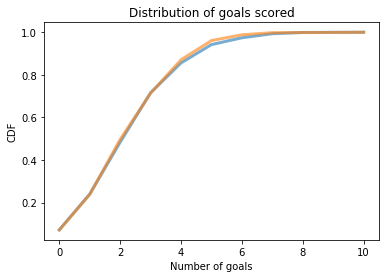

In [103]:
plot_cdfs(sample_sim, sample_bin)

## Poisson process

For large values of `n`, the binomial distribution converges to the Poisson distribution with parameter `mu = n * p`, which is also `mu = lam_per_game`.

In [104]:
mu = lam_per_game
sample_poisson = np.random.poisson(mu, size)
np.mean(sample_poisson)

2.723

And we can confirm that the results are consistent with the simulation and the binomial distribution.

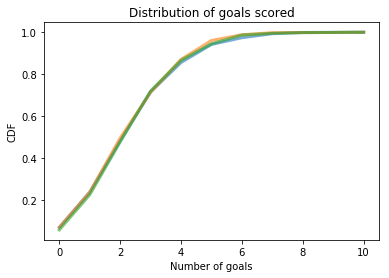

In [105]:
plot_cdfs(sample_sim, sample_bin, sample_poisson)

## Warming up pymc3

Soon we will want to use `pymc3` to do inference, which is really what it's for.  But just to get warmed up, I will use it to generate a sample from a Poisson distribution.

In [106]:
model = pm.Model()

with model:

    goals = pm.Poisson('goals', mu)
    trace = pm.sample(size=size)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [goals]
100%|██████████| 1000/1000 [00:00<00:00, 6499.22it/s]
The number of effective samples is smaller than 25% for some parameters.


In [108]:
sample_pm = trace['goals']
np.mean(sample_pm)

2.53

This example is like using a cannon to kill a fly.  But it help us learn to use the cannon.

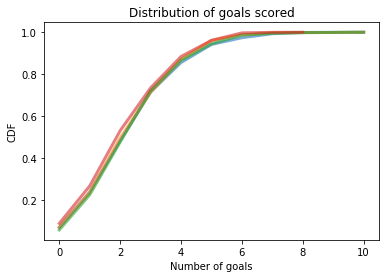

In [109]:
plot_cdfs(sample_sim, sample_bin, sample_poisson, sample_pm)

## Evaluating the Poisson distribution

One of the nice things about the Poisson distribution is that we can compute its CDF and PMF analytically.  We can use the CDF to check, one more time, the previous results.

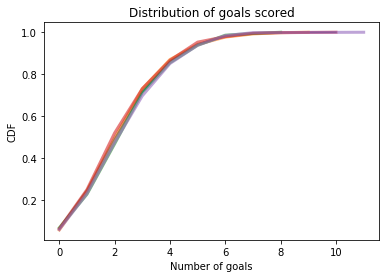

In [20]:
import scipy.stats as st

xs = np.arange(11)
ps = st.poisson.cdf(xs, mu)
plt.plot(xs, ps)

plot_cdfs(sample_sim, sample_bin, sample_poisson, sample_pm)

And we can use the PMF to compute the probability of any given outcome.  Here's what the analytic PMF looks like:

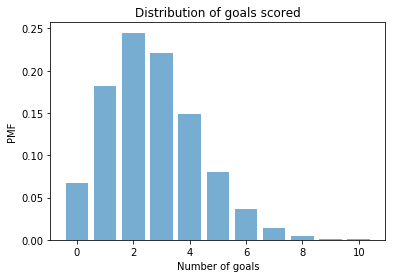

In [110]:
xs = np.arange(11)
ps = st.poisson.pmf(xs, mu)
plt.bar(xs, ps, **plot_options)
pmf_goals()

And here's a function that compute the probability of scoring a given number of goals in a game, for a known value of `mu`.

In [22]:
def poisson_likelihood(goals, mu):
    """Probability of goals given scoring rate.
    
    goals: observed number of goals (scalar or sequence)
    mu: hypothetical goals per game
    
    returns: probability
    """
    return np.prod(st.poisson.pmf(goals, mu))

Here's the probability of scoring 6 goals in a game if the long-term rate is 2.7 goals per game.

In [23]:
poisson_likelihood(goals=6, mu=2.7)

0.036162211957124435

Here's the probability of scoring 3 goals.

In [24]:
poisson_likelihood(goals=3, mu=2.7)

0.21757206844918872

This function also works with a sequence of goals, so we can compute the probability of scoring 6 goals in the first game and 3 in the second.

In [25]:
poisson_likelihood(goals=[6, 3], mu=2.7)

0.006933381207830721

## Bayesian inference with grid methods

Ok, it's finally time to do some inference!  The function we just wrote computes the likelihood of the data, given a hypothetical value of `mu`:

$\mathrm{Prob}~(x ~|~ \mu)$

But what we really want is the distribution of `mu`, given the data:

$\mathrm{Prob}~(\mu ~|~ x)$

If only there were some theorem that relates these probabilities!

The following class implements Bayes's theorem.

In [145]:
class Suite(Pmf):
    """Represents a set of hypotheses and their probabilities."""
    
    def bayes_update(self, data, like_func):
        """Perform a Bayesian update.
        
        data: some representation of observed data
        like_func: likelihood function that takes (data, hypo), where
                   hypo is the hypothetical value of some parameter
        """
        for hypo in self:
            self[hypo] *= like_func(data, hypo)
        self.normalize()
        
    def plot(self, label=None):
        """Plot the hypotheses and their probabilities."""
        xs, ps = self.sorted_items()
        plt.plot(xs, ps, label=label, **plot_options)
        

def pdf_rate():
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel('PDF')
    plt.title('Distribution of goal scoring rate')
    plt.legend()
    
#TODO: Write a version of legend that checks for labels.

I'll start with a uniform prior just to keep things simple.  We'll choose a better prior later.

In [146]:
hypo_mu = np.linspace(0, 20, num=51)
hypo_mu

array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
       13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
       17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ])

Initially `suite` represents the prior distribution of `mu`.

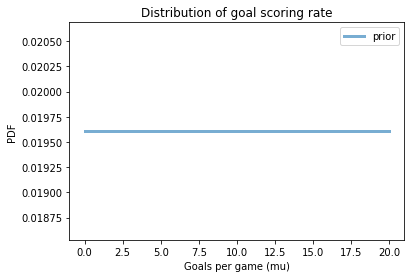

In [147]:
suite = Suite(hypo_mu)
suite.normalize()
suite.plot('prior')
pdf_rate()

Now we can update it with the data and plot the posterior.

No handles with labels found to put in legend.


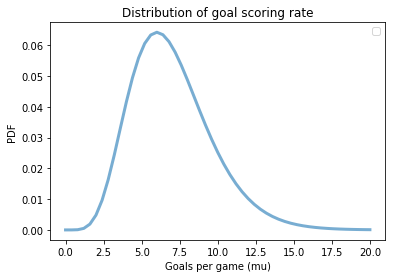

In [148]:
suite.bayes_update(data=6, like_func=poisson_likelihood)
suite.plot()
pdf_rate()

With a uniform prior, the posterior is the likelihood function, and the MAP is the value of `mu` that maximizes likelihood, which is the observed number of goals, 6.

This result is probably not reasonable, because the prior was not reasonable.

## A better prior

To construct a better prior, I'll use scores from previous Stanley Cup finals to estimate the parameters of a gamma distribution.

Why gamma?  You'll see.

Here are (total goals)/(number of games) for both teams from 2013 to 2017, not including games that went into overtime. 

In [128]:
xs = [13/6, 19/6, 8/4, 4/4, 10/6, 13/6, 2/2, 4/2, 5/3, 6/3]

If those values were sampled from a gamma distribution, we can estimate its parameters, `k` and `theta`.

In [129]:
s = np.log(np.mean(xs)) - np.mean(np.log(xs))
s

0.0530280489285232

In [130]:
k = (3 - s + np.sqrt((s-3)**2 + 24*s)) / 12 / s
k

9.590040427964036

In [131]:
theta = np.mean(xs) / k
theta

0.19638429550741368

From here on, I'll use the other way to parameterize the gamma distribution, with `alpha` and `beta`:

In [132]:
alpha = k
beta = 1 / theta

The following function takes `alpha` and `beta` and returns a "frozen" distribution from SciPy's stats module:

In [133]:
def make_gamma_dist(alpha, beta):
    """Returns a frozen distribution with given parameters.
    """
    return st.gamma(a=alpha, scale=1/beta)

The frozen distribution know how to compute its mean and standard deviation:

In [134]:
dist = make_gamma_dist(alpha, beta)
dist.mean(), dist.std()

(1.883333333333333, 0.6081587702831356)

And it can compute its PDF.

In [135]:
hypo_mu = np.linspace(0, 10, num=101)

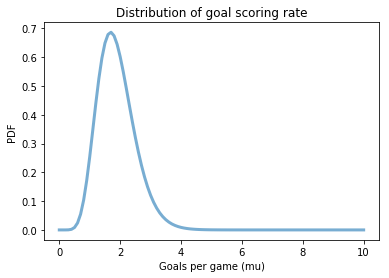

In [136]:
ps = dist.pdf(hypo_mu)
plt.plot(hypo_mu, ps, **plot_options)
pdf_rate()

We can use `make_gamma_dist` to construct a prior suite with the given parameters.

In [137]:
def make_gamma_suite(xs, alpha, beta):
    """Makes a suite based on a gamma distribution.
    
    xs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: Suite
    """
    dist = make_gamma_dist(alpha, beta)
    ps = dist.pdf(xs)
    prior = Suite(dict(zip(hypo_mu, ps)))
    prior.normalize()
    return prior

Here's what it looks like.

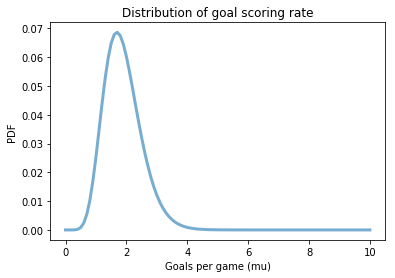

In [138]:
prior = make_gamma_suite(hypo_mu, alpha, beta)
prior.plot()
pdf_rate()

And we can update this prior using the observed data.

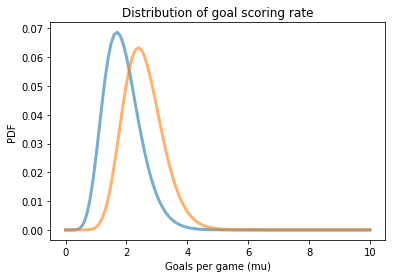

In [139]:
posterior = prior.copy()
posterior.bayes_update(data=6, like_func=poisson_likelihood)
prior.plot()
posterior.plot()
pdf_rate()

The results are substantially different from what we got with the uniform prior.

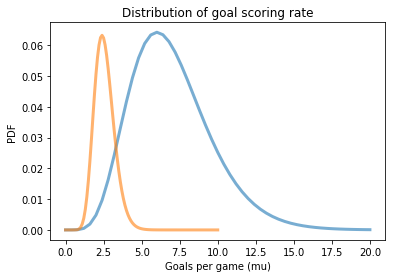

In [140]:
suite.plot()
posterior.plot()
pdf_rate()

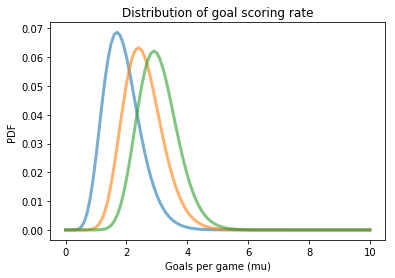

In [44]:
posterior2 = posterior.copy()
posterior2.bayes_update(data=6, like_func=poisson_likelihood)
prior.plot()
posterior.plot()
posterior2.plot()
pdf_rate()

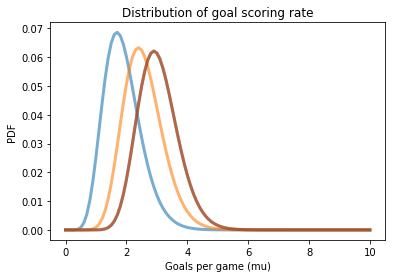

In [45]:
posterior3 = prior.copy()
posterior3.bayes_update(data=[6, 6], like_func=poisson_likelihood)
prior.plot()
posterior.plot()
posterior2.plot()
posterior3.plot()
pdf_rate()

In [46]:
class GammaSuite:
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta
        self.dist = make_gamma_dist(alpha, beta)
    
    def plot(self, xs):
        ps = self.dist.pdf(xs)
        ps /= np.sum(ps)
        plt.plot(xs, ps, **plot_options)
        
    def bayes_update(self, data):
        return GammaSuite(self.alpha+data, self.beta+1)

1.883333333333333

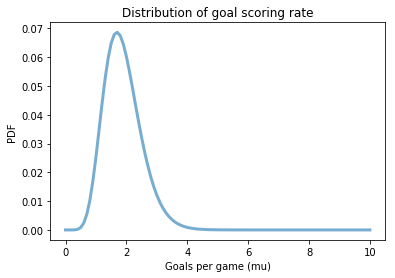

In [47]:
gamma_prior = GammaSuite(alpha, beta)
gamma_prior.plot(hypo_mu)
pdf_rate()
gamma_prior.dist.mean()

2.559076642743212

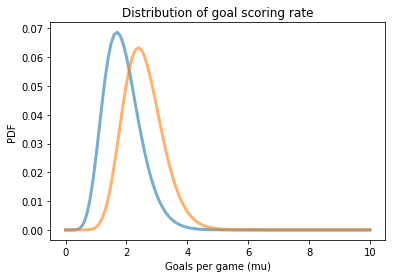

In [48]:
gamma_posterior = gamma_prior.bayes_update(6)
gamma_prior.plot(hypo_mu)
gamma_posterior.plot(hypo_mu)
pdf_rate()
gamma_posterior.dist.mean()

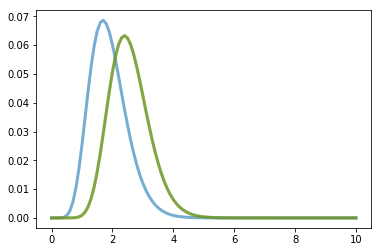

In [49]:
gamma_prior.plot(hypo_mu)
posterior.plot()
gamma_posterior.plot(hypo_mu)

In [50]:
def sample_suite(suite, size):
    xs, ps = suite.sorted_items()
    return np.random.choice(xs, size, replace=True, p=ps)

In [51]:
size = 10000
sample_post = sample_suite(posterior, size)
np.mean(sample_post)

2.54123

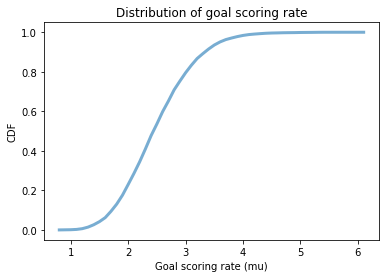

In [54]:
plot_cdf(sample_post)
cdf_rates()

In [55]:
sample_post_pred = np.random.poisson(sample_post)
np.mean(sample_post_pred)

2.5217

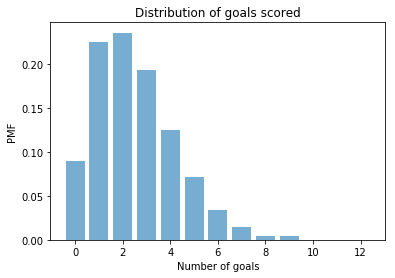

In [56]:
plot_pmf(sample_post_pred)
pmf_goals()

In [58]:
mu_mean = np.mean(sample_post)
sample_post_pred_wrong = np.random.poisson(mu_mean, size)
np.mean(sample_post_pred_wrong)

2.5414

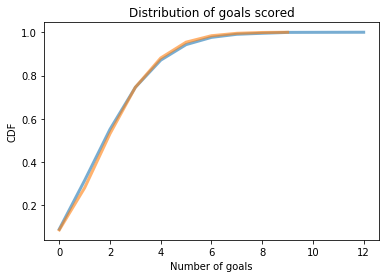

In [73]:
plot_cdf(sample_post_pred)
plot_cdf(sample_post_pred_wrong)
cdf_goals()

In [61]:
np.mean(sample_post_pred), np.mean(sample_post_pred_wrong)

(2.5217, 2.5414)

In [62]:
np.std(sample_post_pred), np.std(sample_post_pred_wrong)

(1.7227678630622294, 1.6145854080846884)

In [63]:
gamma_posterior.alpha / gamma_posterior.beta

2.559076642743212

In [74]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', gamma_posterior.alpha, gamma_posterior.beta)
    trace = pm.sample(size=size, tune=size//2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__]
100%|██████████| 5500/5500 [00:03<00:00, 1548.36it/s]


In [75]:
sample_post_pm = trace['mu']
np.mean(sample_post_pm)

2.5496381018084775

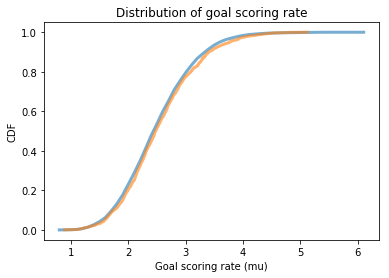

In [76]:
plot_cdf(sample_post)
plot_cdf(sample_post_pm)
cdf_rates()

In [77]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', gamma_posterior.alpha, gamma_posterior.beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample(size=size, tune=size//2)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [mu_log__]
>Metropolis: [goals]
100%|██████████| 5500/5500 [00:04<00:00, 1188.61it/s]
The number of effective samples is smaller than 25% for some parameters.


In [78]:
sample_post_pred_pm = trace['goals']
np.mean(sample_post_pred_pm)

2.467

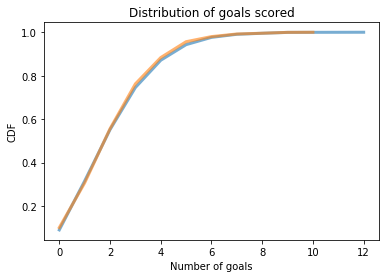

In [79]:
plot_cdf(sample_post_pred)
plot_cdf(sample_post_pred_pm)
cdf_goals()

In [80]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', gamma_prior.alpha, gamma_prior.beta)
    goals = pm.Poisson('goals', mu, observed=6)
    trace = pm.sample(size, tune=size//2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_log__]
100%|██████████| 15000/15000 [00:07<00:00, 1976.75it/s]


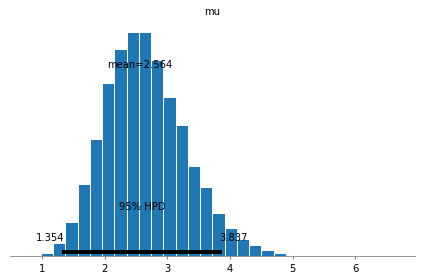

In [81]:
pm.plot_posterior(trace)

In [82]:
sample_post_pm = trace['mu']
np.mean(sample_post_pm)

2.5640151503693778

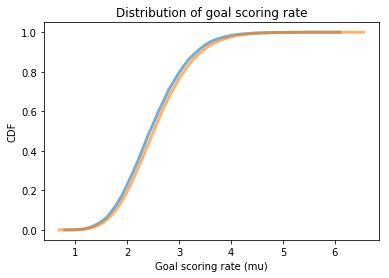

In [83]:
plot_cdf(sample_post)
plot_cdf(sample_post_pm)
cdf_rates()

In [84]:
with model:
    post_pred = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 4103.47it/s]


In [85]:
post_pred_pm = post_pred['goals']
np.mean(post_pred_pm)

2.58

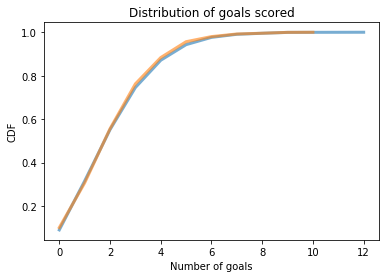

In [86]:
plot_cdf(sample_post_pred)
plot_cdf(sample_post_pred_pm)
cdf_goals()